In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import expon
from scipy.stats import uniform
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.special import erf
from scipy.special import hyp1f1
from scipy.linalg import eigh
from random import randint
from scipy.optimize import fsolve
from scipy.optimize import root
from numpy.polynomial import legendre

## simulation

In [2]:
def intensity(t,history,parameters):    #left continue
    mu=parameters[0]
    alpha=parameters[1]
    beta=parameters[2]
    intensity=0
    for i in range(len(history)):
        if history[i]>=t:
            break
        intensity+=alpha*np.exp(-beta*(t-history[i]))
    return mu+intensity

In [3]:
def hawkes_simulation_expo(T,parameters):
    t=0
    jump=0
    points_homo=[]
    points_hawkes=[]
    while(t<T):
        points_homo.append(t)
        intensity_sup=intensity(t,points_hawkes,parameters)+jump
        r=expon.rvs(scale=1/intensity_sup) #scale=1/lamda
        t+=r
        D=uniform.rvs(loc=0,scale=1)
        if D*intensity_sup<=intensity(t,points_hawkes,parameters):
            points_hawkes.append(t)
            jump=parameters[1]
        else:
            jump=0
    if points_hawkes[-1]>T:
        del points_hawkes[-1]
    del points_homo[0]
    return points_hawkes

In [4]:
def negtiveloglikelyhood1(parameters, times, T): #times=timestamp t1-tn; T is timespan      fast:R(i)
    times=np.array(times)
    
    mu=parameters[0]
    alpha=parameters[1]
    beta=parameters[2]
    
    timedifference=T-times #T-t0...T-t(n-1) 
    timeexponential=np.exp(-beta*timedifference)-1
    secondsum=alpha/beta*sum(timeexponential)
    
    R=np.zeros((len(times),1))
    for i in range(1,len(times)):
        R[i]=np.exp(-beta*(times[i]-times[i-1]))*(1+R[i-1])
    firstsum=sum(np.log(mu+alpha*R))  #left-continuous
    
    negtivelogl=-(firstsum-mu*T+secondsum)
    return negtivelogl

In [5]:
T=100

In [11]:
points_hawkes=hawkes_simulation_expo(T,[1,1,2]) ## 1 set of training data, which can be more. 

In [12]:
len(points_hawkes)

233

## Parametric Hawkes (MLE)

In [13]:
parameters=np.array([1.2,0.7,3])
res=optimize.minimize(negtiveloglikelyhood1, parameters,args=(points_hawkes,T), method='SLSQP', bounds=((0.01,5),(0.01,5),(0.01,5)), options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.791635698093259
            Iterations: 13
            Function evaluations: 71
            Gradient evaluations: 13


In [14]:
res.x

array([1.01948561, 0.83240627, 1.47317018])

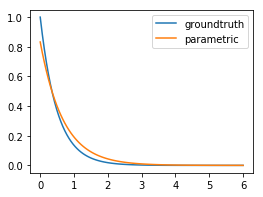

In [15]:
plt.figure(1,figsize=(4,3))
axs=plt.subplot(111)
axs.plot(np.linspace(0,6,100),1*np.exp(-2*np.linspace(0,6,100)),label='groundtruth')
axs.plot(np.linspace(0,6,100),res.x[1]*np.exp(-res.x[2]*np.linspace(0,6,100)),label='parametric')
plt.legend()
plt.show()

## inference

In [16]:
def expo_quad_kernel(theta0,theta1,xn,xm):
    return theta0*np.exp(-theta1/2*np.sum((xn - xm)**2))

In [17]:
def GP_regression(xi,yi,theta0,theta1,noise_var,rang,num_points):
    N=len(xi)
    cov_K=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            cov_K[i][j]=expo_quad_kernel(theta0,theta1,xi[i],xi[j])
            cov_K[j][i]=cov_K[i][j]
    min_eig=np.min(np.real(np.linalg.eigvals(cov_K))) # numerical float truncation error refine
    while(min_eig<0):
        cov_K += -10*min_eig*np.eye(cov_K.shape[0])
        min_eig=np.min(np.real(np.linalg.eigvals(cov_K)))
    
    cov_K_noise=cov_K+np.eye(N)*noise_var
    
    x1=np.linspace(0,rang,num_points+1)      # prediction points, integer is to make it easy
    M=len(x1)-1
    mean=np.zeros((1,M))[0]
    posterior_cov=np.zeros((M,M))
    k_matrix=np.zeros((M,N))
    k_matrix_pre=np.zeros((M,M))
    for i in range(M):
        for j in range(N):
            k_matrix[i][j]=expo_quad_kernel(theta0,theta1,x1[i],xi[j])
    k_C=np.dot(k_matrix,np.linalg.inv(cov_K_noise))
    mean=np.dot(k_C,yi)
    for i in range(M):
        for j in range(i,M):
            k_matrix_pre[i][j]=expo_quad_kernel(theta0,theta1,x1[i],x1[j])
            k_matrix_pre[j][i]=k_matrix_pre[i][j]
    posterior_cov=k_matrix_pre-np.dot(k_C,k_matrix.T)+np.eye(M)*noise_var
    min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov))) # numerical float truncation error refine
    while(min_eig<0):
        posterior_cov += -10*min_eig*np.eye(posterior_cov.shape[0])
        min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov)))
    return x1[:num_points],mean, posterior_cov

In [18]:
def u_generate(theta0,theta1,xi): # xi is inducing points, N(0,Sigma)
    N=len(xi)
    cov=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            cov[i][j]=expo_quad_kernel(theta0,theta1,xi[i],xi[j])
            cov[j][i]=cov[i][j]
    return multivariate_normal([0]*N,cov).rvs(),np.array([0]*N),cov

In [19]:
T_phi=6

In [20]:
xi=np.linspace(0+(T_phi/10)/2,T_phi-(T_phi/10)/2,6)   # 6 inducing points on \phi(\tau)

## \phi part

In [21]:
theta0=1
theta1=0.5

In [22]:
u,mean_p_u,cov_p_u=u_generate(theta0,theta1,xi)

In [23]:
f=GP_regression(xi,u,theta0,theta1,0.000001,T_phi,100) # f is 100-dimension vector on [0,T_phi]

In [24]:
f_1=multivariate_normal(f[1],f[2]).rvs() # f sample

## EM framework

In [25]:
def ini_P(points_hawkes,T_phi):
    N=len(points_hawkes)
    P=np.zeros((N,N))
    for i in range(N):                    # initial value of P
        for j in range(i+1):
            tij=points_hawkes[i]-points_hawkes[j]
            if tij>=T_phi:continue
            else:
                P[i][j:i+1]=np.random.dirichlet([1]*(i-j+1))
                break
    return P

In [26]:
def psi(theta0,theta1,xn,xm,T):
    x_mean=(xn+xm)/2
    return (theta0**2)*(-np.sqrt(np.pi/theta1)/2)*np.exp((-theta1*(xn-xm)**2)/4)*(erf((x_mean-T)*np.sqrt(theta1))\
                                                                                  -erf(x_mean*np.sqrt(theta1)))

In [27]:
def distribution_f_posterior(x_f,xi,theta0,theta1,cov_p_u,cov_q_u_post):
    N=len(xi) # N is number of inducing points
    M=len(x_f) # M is number of predicting points
    
    cov_p_u_inv=np.linalg.inv(cov_p_u)
    
    K_xz=np.zeros((M,N))
    for i in range(M):
        for j in range(N):
            K_xz[i][j]=expo_quad_kernel(theta0,theta1,x_f[i],xi[j])
#     K_xx=np.zeros((M,M))
#     for i in range(M):
#         for j in range(i,M):
#             K_xx[i][j]=expo_quad_kernel(theta0,theta1,x_f[i],x_f[j])
#             K_xx[j][i]=K_xx[i][j]
#     mean_f=(K_xz.dot(cov_p_u_inv)).dot(mean_q_u_post)
#     cov_f=K_xx-(K_xz.dot(cov_p_u_inv)).dot(K_xz.T)+(((K_xz.dot(cov_p_u_inv)).dot(cov_q_u_post)).dot(cov_p_u_inv)).dot(K_xz.T)
    var_f=np.array([theta0-K_xz[i].dot(cov_p_u_inv).dot(K_xz[i].T)+(((K_xz[i].dot(cov_p_u_inv)).dot(cov_q_u_post)).dot(cov_p_u_inv)).dot(K_xz[i].T) for i in range(M)])
    
    exp_phi=var_f
    return exp_phi

## \mu is constant

In [28]:
def eq(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M,m):
    y=0
    s=p
    for i in range(1,len(k_K_k)):
        for j in range(i):
            if P[i][j]!=0:
                y+=k_K_K_k[i][j][m]*P[i][j]/(k_K_k[i][j]+sum([(k_K[i][j][k]**2)*s[k] for k in range(M)]))
    y+=-secondterm[m]-0.5*thirdterm[m]+0.5/s[m]
    return y

In [29]:
def equations(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M):
    return [eq(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M,i) for i in range(M)]

In [30]:
def MISD_variational_deri_mu_cons(points_hawkes,xi,T_phi,T,num_iter): # 100 predict points on T_phi, 1000 predict points on T
    N=len(points_hawkes) # num of observation
    M=len(xi)            # num of inducing points on phi
    P=ini_P(points_hawkes,T_phi)
    delta_t=T_phi/len(f[0]) # phi is discete to 100 points
    
    #__________________initial setting of phi
    cov_q_u_diag=np.random.uniform(0,1,M)
    cov_p_u_inv=np.linalg.inv(cov_p_u)
    thirdterm=np.diagonal(cov_p_u_inv)
    n_1=sum(np.array(points_hawkes)<(T-T_phi)) # num of points within T-T_phi
    Psi=np.zeros((N,M,M))
    for i in range(n_1):
        for j in range(M):
            for k in range(j,M):
                Psi[i][j][k]=psi(theta0,theta1,xi[j],xi[k],T_phi)
                Psi[i][k][j]=Psi[i][j][k]
    for i in range(n_1,N):
        for j in range(M):
            for k in range(j,M):
                Psi[i][j][k]=psi(theta0,theta1,xi[j],xi[k],T-points_hawkes[i])
                Psi[i][k][j]=Psi[i][j][k]
    secondterm=sum([np.diagonal(cov_p_u_inv.dot(Psi[i]).dot(cov_p_u_inv)) for i in range(N)])
    k_tn_z=np.zeros((N,N,M))
    for i in range(1,N):
        for j in range(i):
            if P[i][j]!=0:
                tao=points_hawkes[i]-points_hawkes[j]
                k_tn_z[i][j]=np.array([expo_quad_kernel(theta0,theta1,tao,xi[k]) for k in range(M)])            
    k_K_K_k=np.zeros((N,N,M))   # matrix of vector   #     1st term
    k_K_k=np.zeros((N,N))    # matrix of value
    k_K=np.zeros((N,N,M))     # matrix of vector
    for i in range(1,N):
        for j in range(i):
            if P[i][j]!=0:
                k_K_K_k[i][j]=np.diagonal(cov_p_u_inv.dot(np.array([k_tn_z[i][j]]).T).dot(np.array([k_tn_z[i][j]])).dot(cov_p_u_inv))
                k_K_k[i][j]=theta0-k_tn_z[i][j].dot(cov_p_u_inv).dot(k_tn_z[i][j].T)
                k_K[i][j]=k_tn_z[i][j].dot(cov_p_u_inv)
    
    
    
    
    
    for k in range(num_iter):  # num of iterations
        # update of phi
        
        cov_q_u_diag=fsolve(equations,cov_q_u_diag, args=(P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M))
        cov_q_u_diag[cov_q_u_diag<0] = 0.1 # more stable
        cov_q_u=np.diag(cov_q_u_diag)
        phi=distribution_f_posterior(f[0],xi,theta0,theta1,cov_p_u,cov_q_u)
        
        # update of mu
        
        mu=sum(np.diagonal(P))/T

        
        for i in range(N): # updata of P
            intensity_total=0
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_phi: continue
                intensity_total+=phi[int(tji/delta_t)]
            intensity_total+=mu
            P[i][i]=mu/intensity_total
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_phi: P[i][j]=0
                else: P[i][j]=phi[int(tji/delta_t)]/intensity_total
    return mu,phi

In [31]:
%%time
mu_var,phi_var=MISD_variational_deri_mu_cons(points_hawkes,xi,T_phi,T,200)

Wall time: 8min 28s


In [32]:
mu_var

0.7916303066994739

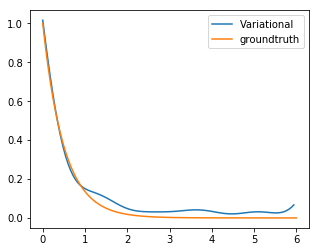

In [35]:
plt.figure(1,figsize=(5,4))
axs=plt.subplot(111)
axs.plot(f[0],phi_var,label='Variational')
axs.plot(np.linspace(0,6,100),1*np.exp(-2*np.linspace(0,6,100)),label='groundtruth')
plt.legend()
plt.show()

## MISD

In [36]:
def MISD(points_hawkes,T,T_gamma,delta_t,num_iter):
    num_g=int(T_gamma/delta_t)
    N=len(points_hawkes)
    P=ini_P(points_hawkes,T_gamma)
    g=np.zeros((1,num_g), dtype=float)

    for k in range(num_iter):
        for m in range(num_g): # update for u and g
            rate_prob=np.zeros((1,N))
            div_num=0
            for i in range(N):
                if (T-points_hawkes[i])>=m*delta_t and (T-points_hawkes[i])<(m+1)*delta_t: # point i is close to T
                    div_num+=1
                    for j in range(i+1,N):
                        interval=points_hawkes[j]-points_hawkes[i]
                        if interval>=m*delta_t and interval<(m+1)*delta_t:
                            rate_prob[0][i]+=P[j][i]
                        elif interval>=(m+1)*delta_t:
                            break
                    rate_prob[0][i]=rate_prob[0][i]/(T-m*delta_t)
                elif (T-points_hawkes[i])<m*delta_t:
                    break
                else:
                    div_num+=1
                    for j in range(i+1,N):
                        interval=points_hawkes[j]-points_hawkes[i]
                        if interval>=m*delta_t and interval<(m+1)*delta_t:
                            rate_prob[0][i]+=P[j][i]
                        elif interval>=(m+1)*delta_t:
                            break
                    rate_prob[0][i]=rate_prob[0][i]/delta_t
            if div_num==0:
                break
            else:
                g[0][m]=sum(rate_prob[0])/div_num
        u=sum(P[i][i] for i in range(N))/T

        for i in range(N): # updata for P
            intensity_total=0
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_gamma: continue
                intensity_total+=g[0][int(tji/delta_t)]
            intensity_total+=u
            P[i][i]=u/intensity_total
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_gamma: P[i][j]=0
                else: P[i][j]=g[0][int(tji/delta_t)]/intensity_total
    return u,g[0]

In [37]:
u_misd_10,phi_misd_10=MISD(points_hawkes,T,T_phi,0.6,200)

In [38]:
u_misd_20,phi_misd_20=MISD(points_hawkes,T,T_phi,0.3,200)

In [39]:
u_misd_10

0.9245680044056881

In [40]:
u_misd_20

0.7659320919271453

## Wiener-Hopf method

In [41]:
def hawkes_second_stats_conti_gauss(t,h,points_hawkes,T):   # gaussian kernel
    N=len(points_hawkes)
    Lamda=N/T
    g_t_i=[]
    for i in range(N):
        if points_hawkes[i]+t>T-h:
            break
        else:
            g_t=np.exp(-(((t-(points_hawkes[:i]+points_hawkes[i+1:]-points_hawkes[i]))/h)**2/2))
            g_t_i.append(sum(g_t)/np.sqrt(2*np.pi)/h)
    return np.average(g_t_i)-Lamda

In [42]:
def primitive_g(t,g,range_g): # -infinity to t
    delta_t=range_g/len(g)
    num_bin=t/delta_t
    if num_bin<len(g):
        integral=sum(g[:int(num_bin)])*delta_t+g[int(num_bin)]*delta_t*(num_bin-int(num_bin))
    else:
        integral=sum(g)*delta_t
    return integral+sum(g)*delta_t

In [43]:
def gq_points_weights(a,b,Q):
    p,w=np.polynomial.legendre.leggauss(Q)
    c = np.array([0]*Q + [1])
    p_new=(a+b+(b-a)*p)/2
    w_new=(b-a)/(legendre.legval(p, legendre.legder(c))**2*(1-p**2))
    return p_new,w_new

In [44]:
def phi_WH_prediction(t,g,Q,range_g): 
    delta_t=range_g/len(g) 
    p,w=gq_points_weights(0,range_g,Q)  # (0,infininty) replaced by (0,range_g)
    g_ti=np.zeros((Q,Q))
    G_ti=np.zeros((1,Q))[0]
    for i in range(Q):
        G_ti[i]=primitive_g(p[i],g,range_g)
        for j in range(i,Q):
            if i==j:
                g_ti[i][i]=g[int(p[i]/delta_t)]
            else:
                g_ti[i][j]=g[int((p[j]-p[i])/delta_t)]
                g_ti[j][i]=g_ti[i][j]
    
    a = np.zeros((Q,Q))
    b = np.zeros((1,Q))[0]
    for i in range(Q):
        b[i]=g_ti[i][i]
        for j in range(Q):
            if i==j:
                a[i][i]=1+G_ti[i]-sum(w*g_ti[i])+w[i]*g_ti[i][i]  #diagonal
            else:
                a[i][j]=w[j]*g_ti[i][j]    
    phi_ti = np.linalg.solve(a,b)

    g_t=g[int(t/delta_t)]
    G_t=primitive_g(t,g,range_g)
    g_t_ti=np.zeros((1,Q))[0]
    for i in range(Q):
        g_t_ti[i]=g[int((t-p[i])/delta_t)]
    phi_t=(g_t-sum(w*phi_ti*g_t_ti))/(1+G_t-sum(w*g_t_ti))
    return phi_t

In [45]:
def phi_parameter(x,h,Q,range_g):# default range_g*10 points
#     x=np.linspace(0.1/2,range_g-0.1/2,range_g*10)
    g_gauss=[hawkes_second_stats_conti_gauss(x_i,h,points_hawkes,T) for x_i in x]
    phi_result=[phi_WH_prediction(xi,g_gauss,Q,range_g) for xi in x]
    
#     mse=sum((np.array(phi_result)-1*np.exp(-2*x))**2)/(range_g*10)
    return phi_result

In [46]:
phi_wh=phi_parameter(f[0],0.7,100,T_phi)

In [47]:
u_wh=len(points_hawkes)/T*(1-sum(T_phi/len(f[0])*np.array(phi_wh)))

In [48]:
u_wh

0.7050242301600926

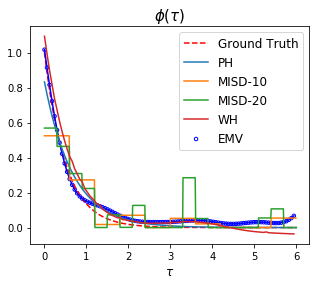

In [49]:
plt.figure(1,figsize=(5,4))
axs=plt.subplot(111)
axs.plot(np.linspace(0,6,100),1*np.exp(-2*np.linspace(0,6,100)),'r--',label='Ground Truth')
axs.plot(f[0],phi_var,'b')
axs.scatter(f[0],phi_var,marker='o',s=12,c='',edgecolors='b',label='EMV')
axs.plot(np.linspace(0,6,100),res.x[1]*np.exp(-res.x[2]*np.linspace(0,6,100)),'-',label='PH')
axs.plot(np.linspace(0,6,600,endpoint=False),[phi_misd_10[int(xxx/0.6)] for xxx in np.linspace(0,6,600,endpoint=False)],label='MISD-10')
axs.plot(np.linspace(0,6,600,endpoint=False),[phi_misd_20[int(xxx/0.3)] for xxx in np.linspace(0,6,600,endpoint=False)],label='MISD-20')
axs.plot(f[0],phi_wh,label='WH')
plt.xlabel(r'$\tau$',fontsize=12)
plt.title(r'$\phi(\tau)$',fontsize=15)
plt.legend(fontsize=12)

# plt.savefig('c:/Users/zho045/Desktop/phi_case_1',bbox_inches = 'tight')
plt.show()

## EMV esterr

In [50]:
sum((1*np.exp(-2*f[0])-phi_var)**2*(T_phi/len(f[0])))

0.0061866418691183004

## WH esterr

In [51]:
sum((1*np.exp(-2*f[0])-phi_wh)**2*(T_phi/len(f[0])))

0.016065693693825708

## MISD-10 esterr

In [52]:
sum((1*np.exp(-2*f[0])-(np.array([phi_misd_10[int(xxx/0.6)] for xxx in np.linspace(0,6,100,endpoint=False)])))**2*(T_phi/len(f[0])))

0.045121628037981656

## MISD-20 esterr

In [53]:
sum((1*np.exp(-2*f[0])-(np.array([phi_misd_20[int(xxx/0.3)] for xxx in np.linspace(0,6,100,endpoint=False)])))**2*(T_phi/len(f[0])))

0.06295143102149496

## PH esterr

In [54]:
1**2/(2*2)+res.x[1]**2/(2*res.x[2])-2*1*res.x[1]/(2+res.x[2])

0.005838021227420664

## \mu esterr

In [55]:
(mu_var-1)**2*T

4.341792908615532

In [56]:
(u_wh-1)**2*T

8.7010704792646

In [57]:
(u_misd_10-1)**2*T

0.5689985959340291

In [58]:
(u_misd_20-1)**2*T

5.4787785589602365

In [59]:
(res.x[0]-1)**2*T

0.03796888251905864

## test loglikelihood

In [60]:
def intensity_discrete(t,history,u,g_mean,T_phi):    #left continue, the intensity is a gaussian dist
    mu=u
    N=len(g_mean)
    intensity_mean=0
    for i in range(len(history)):
        if history[i]>=t:
            break
        delta_t=t-history[i]
        if delta_t<T_phi:
            intensity_mean+=g_mean[int(delta_t*N/T_phi)]
    return mu+intensity_mean

In [61]:
def negtiveloglikelihood_discrete(u,g_mean,times,T_phi,T):
    N=len(times)
    M=len(g_mean)
    logl=0
    for i in range(N):
        logl+=np.log(intensity_discrete(times[i],times,u,g_mean,T_phi))
        delta_t=T-times[i]
        if delta_t>=T_phi:
            logl-=sum(g_mean*T_phi/M)
        else:
            temp=(delta_t)*M/T_phi
            temp_int=int(temp)
            logl-=sum(g_mean[:temp_int]*T_phi/M)+g_mean[temp_int]*T_phi/M*(temp-temp_int)
    return -(logl-u*T)

In [63]:
points_hawkes_test=[]         ## 10 sets of test data
for i in range(10):
    points_hawkes_test.append(hawkes_simulation_expo(T,[1,1,2]))

### PH

In [64]:
logLik_PH=[]
for i in range(10):
    logLik_PH.append(-negtiveloglikelyhood1(res.x, points_hawkes_test[i], T))

In [65]:
np.average(logLik_PH)

-42.11428632003293

### MISD-10

In [66]:
logLik_misd_10=[]
for i in range(10):
    logLik_misd_10.append(-negtiveloglikelihood_discrete(u_misd_10,phi_misd_10,points_hawkes_test[i],T_phi,T))

In [67]:
np.average(logLik_misd_10)

-44.23896701781671

### MISD-20

In [68]:
logLik_misd_20=[]
for i in range(10):
    logLik_misd_20.append(-negtiveloglikelihood_discrete(u_misd_20,phi_misd_20,points_hawkes_test[i],T_phi,T))

In [69]:
np.average(logLik_misd_20)

-46.198771429296

### WH

In [70]:
logLik_wh=[]
for i in range(10):
    logLik_wh.append(-negtiveloglikelihood_discrete(u_wh,np.array(phi_wh),points_hawkes_test[i],T_phi,T))

In [71]:
np.average(logLik_wh)

-43.8752976886336

### EMV

In [72]:
logLik_var=[]
for i in range(10):
    logLik_var.append(-negtiveloglikelihood_discrete(mu_var,phi_var,points_hawkes_test[i],T_phi,T))

In [73]:
np.average(logLik_var)

-43.02481407059032